In [88]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [81]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns = [target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [2]:
train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id')
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [3]:
sites = ['site%s' %i for i in range(1,11)]
times = ['time%s' %i for i in range(1,11)]

In [4]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = train_df[times].apply(pd.to_datetime)

In [5]:
for i in range(1,11):
    train_df['weekday%s' %i] = train_df['time%s' %i].dt.weekday.fillna(-1).astype('int')
    test_df['weekday%s' %i] = test_df['time%s' %i].dt.weekday.fillna(-1).astype('int')

In [6]:
weekdays = ['weekday%s'%i for i in range(1,11)]

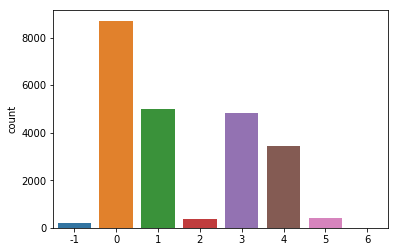

In [12]:
sns.countplot(train_df[train_df['target']==1][weekdays].values.flatten())

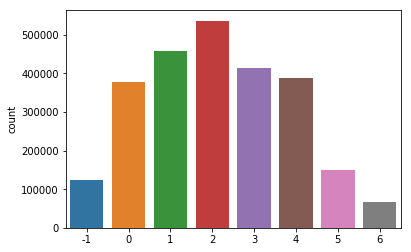

In [13]:
sns.countplot(train_df[train_df['target']==0][weekdays].values.flatten())

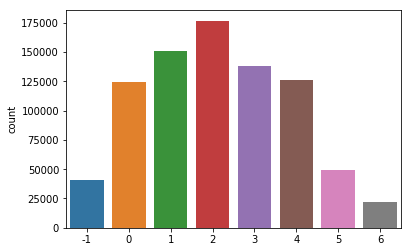

In [28]:
sns.countplot(test_df[weekdays].values.flatten())

CountVectorize all the sites, and use the weekday of site 1 to predict the target

In [34]:
train_df[sites].fillna(0).astype('int').to_csv('data/train_sessions_text.csv', sep=' ', header=None, index=None)
test_df[sites].fillna(0).astype('int').to_csv('data/test_sessions_text.csv', sep=' ', header=None, index=None)

In [55]:
%%time

cv = CountVectorizer(ngram_range=(1,3), max_features=50000)
with open('data/train_sessions_text.csv') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('data/test_sessions_text.csv') as inp_test_file:
    X_test = cv.transform(inp_test_file)

X_train.shape, X_test.shape

Wall time: 24.1 s


In [39]:
y_train = train_df['target']

In [66]:
enc = OneHotEncoder(categories = 'auto')
train_weekdays = train_df[weekdays]
test_weekdays = test_df[weekdays]
train_weekdays = enc.fit_transform(train_weekdays)
test_weekdays = enc.transform(test_weekdays)

In [74]:
X_train_new = csr_matrix(hstack([X_train,train_weekdays]))
X_test_new = csr_matrix(hstack([X_test,test_weekdays]))

In [76]:
logit = LogisticRegression(class_weight='balanced', verbose=True, n_jobs=-1)

In [86]:
idx_split = round(X_train_new.shape[0]*0.8)

202849

In [92]:
logit.fit(X_train_new[:idx_split,:],y_train[:idx_split])

C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=True, warm_start=False)

In [99]:
y_cv = logit.predict_proba(X_train_new[idx_split:,:])
roc_auc_score(y_train[idx_split:],y_cv[:,1])
#roc_auc_score(y_train[idx_split:],logit.predict_proba(X_train_new[idx_split:,:]))

0.9536041773584981

In [100]:
y_pred = logit.predict_proba(X_test_new)[:,1]

In [101]:
write_to_submission_file(y_pred, 'data/subm1_29_1.csv')

In [102]:
!kaggle competitions submit -c catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2 -f data/subm1_29_1.csv -m "Bag of Words with weekday feature. CV = 95.36"

Successfully submitted to Catch Me If You Can



  0%|          | 0.00/2.26M [00:00<?, ?B/s]
  0%|          | 8.00k/2.26M [00:00<01:14, 31.8kB/s]
  5%|5         | 120k/2.26M [00:00<00:50, 44.8kB/s] 
 20%|#9        | 456k/2.26M [00:00<00:29, 63.6kB/s]
 27%|##7       | 632k/2.26M [00:00<00:19, 89.4kB/s]
 79%|#######9  | 1.79M/2.26M [00:00<00:03, 127kB/s]
 99%|#########8| 2.23M/2.26M [00:00<00:00, 179kB/s]
100%|##########| 2.26M/2.26M [00:06<00:00, 369kB/s]
